# How to delta hedge an option: Part II

## Delta, Gamma and an intuitive example

In Part I we covered the real basics of what an option is and some straight forward relationships between an option's price and the underlying stock's price. Here the aim is to develop that intuition further by utilising an example to demonstrate clearly how 'risk minimising' delta hedging behaviour generates money and how that money is related to 'time value' of an option.

We left off in the previous article having just arrived at the fact that time has value - given the choice we'd rather own an option with more time to expiry vs one with less time to expiry (all other things being equal).

## Can we visualise this relationship?

In other words, compared to our previous 'hockey stick' graphs that just show the terminal value of an option, how do option values look pre-expiry? The exact shape of the below graphs is not important for now but will be explained later - all that's important is that the above ideas are represented in the various lines on the graph.

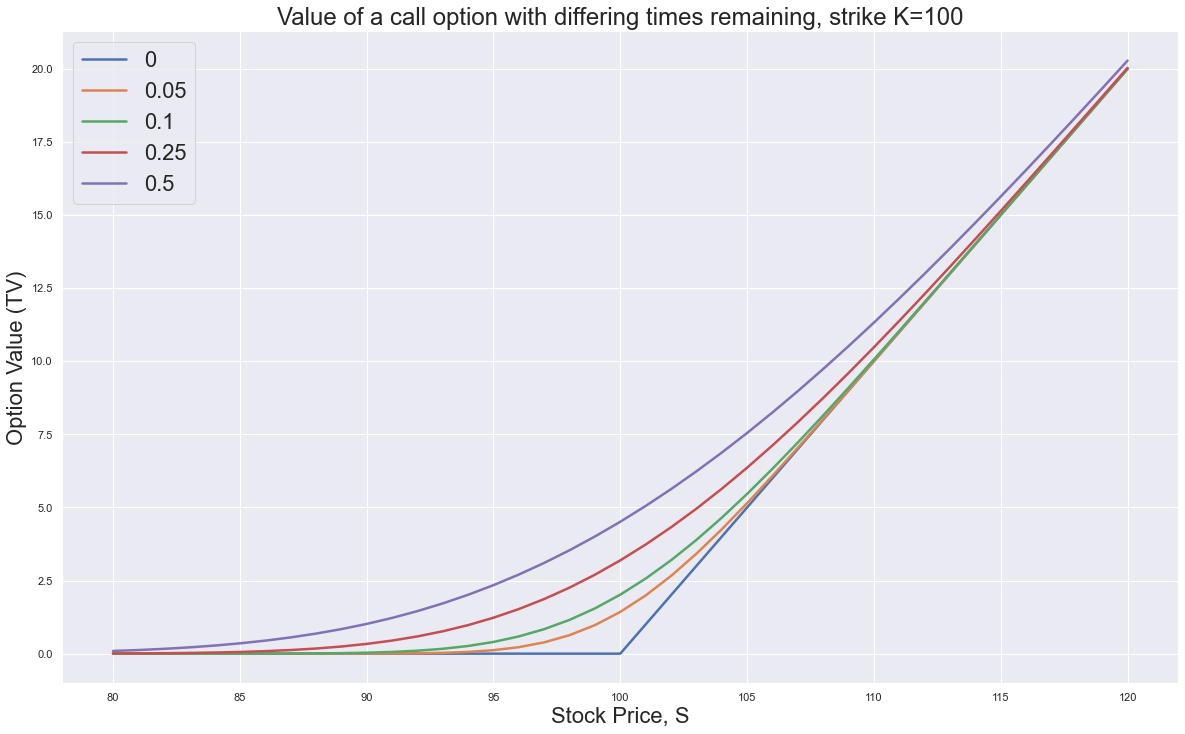

In [10]:
# functions to compute Black-Scholes option prices
def bs_d_one(S, K, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (sigma**2)/2 * delta_T)

def compute_prices(pxs, K, sigma, T, call=True):
    
    # calculate d1 and d2
    d_one = bs_d_one(pxs, K, sigma, T)
    d_two = d_one - sigma * T**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * deltas - stats.norm.cdf(d_two) * K
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K + deltas * pxs
    
    return prices, deltas

# inputs
K = 100
sigma = 0.16
pxs = np.linspace(80, 120, 41)
times = [0.05, 0.1, 0.25, 0.5]
res = {}

# compute terminal payoof
call_pnls = [max(0, s - K) for s in pxs]

# compute option prices
for t in times:
    op_pxs = compute_prices(pxs, K, sigma, t, call=True)
    res[t] = op_pxs[0]

# plot
fig, ax = plt.subplots(figsize=(20,12))

ax.plot(pxs, call_pnls, lw=2.5, label='0')
for l, ps in res.items():
    ax.plot(pxs, ps, lw=2.5, label=l)

# label
ax.set_title('Value of a call option with differing times remaining, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

So just as before we have our 'hockey stick' graph that corresponds to having 'zero time to expiry' - the blue line on the graph above. However now we have these curved lines for what the value of our call option may be _before_ expiry. Do these lines corroborate the above conclusions we drew?
 - they are all above the blue line - this corroborates the idea that time has a strictly positive value
 - they maintain the rough slope of the blue line - we have close to zero sensitivity to the underlying stock price way below the strike and a sensitivity close to 1 way above

However there's a key difference versus the blue 'hockey stick' line: __our new lines that represent our call option value are nice and smooth vs the stock price.__ We've lost that characterising kink. And when we see smooth lines there's one idea that should spring to mind.

## Enter differentiation

Now we have a situation where we:
 - care about how the price of the call option relates to the price of the underlying stock
 - it appears like this relationship is smooth at all the different stock prices (there are no kinks in the pre-expiry payoff lines)

If we revisit the idea that we had above - trying to find a relationship between the call option price and the stock price it now seems like we have a way to do that - __it will be the slope of the lines on our graph.__ Taking just one of the lines on the above graph we can plot another graph side by side - the graph of the slope of that line. Some things we would expect:
 - when we are way below the strike price the slope should be around `0`
 - when we are way above it should be around `1`
 - when we are inbetween it should move smoothly from zero to `1` with the greatest change happening around the strike `K` (because this is where the line is 'most curvy' above)

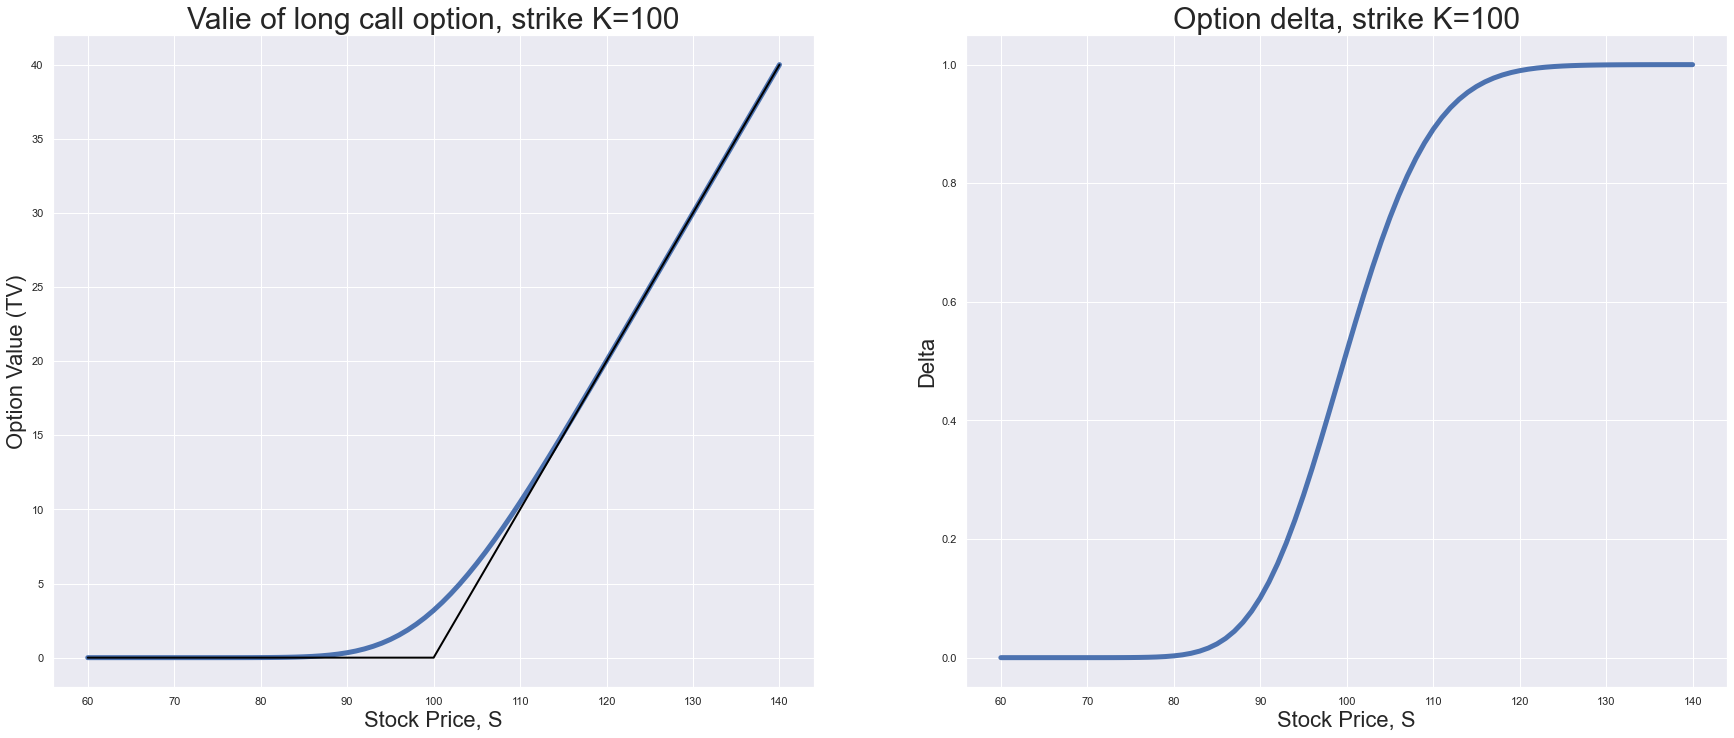

In [11]:
# inputs
K = 100
sigma = 0.16
pxs = np.linspace(60, 140, 81)

# compute terminal payoff
call_exp = [max(0, s - K) for s in pxs]
# compute call prices
call_pxs = compute_prices(pxs, K, sigma, 0.25, call=True)

# plot
fig, axes = plt.subplots(ncols=2, figsize=(30,12))
axes = axes.reshape(-1)

axes[0].plot(pxs, call_pxs[0], lw=5)
axes[0].plot(pxs, call_exp, lw=2, color='black')

axes[0].set_title('Valie of long call option, strike K={}'.format(K), fontsize=30)
axes[0].set_xlabel('Stock Price, S', fontsize=22)
axes[0].set_ylabel('Option Value (TV)', fontsize=22);


axes[1].plot(pxs, call_pxs[1], lw=5)

axes[1].set_title('Option delta, strike K={}'.format(K), fontsize=30)
axes[1].set_xlabel('Stock Price, S', fontsize=22)
axes[1].set_ylabel('Delta', fontsize=22);

So the graph on the left is nothing new - it's just one of the above lines plotted against the terminal 'hockey stick' payoff we have had all along. The graph on the left then shows how the slope of this line varies at different levels of the underlying stock price, `S`. And again, as we have already established this slope can be interpreted as the sensitivity of the option price to the underlying price.

Now we finally have an answer for why I plucked `0.5` out of the air for the above simple hedging example (when we bought the call option and sold `0.5` shares to 'hedge' it). Because it looks like the sensitivity for options when our underlying stock price, `S`, is close to the strike price, `K`, is roughly `0.5`. In words, this means that for a small move up in the underlying stock price `S`, if we had sold `0.5` stocks then:
 - we would make money on being long the call option (established above)
 - we would lose money on selling these shares

__and these sums of money would be exactly equal and opposite so that we would not make or lose any money.__ This is pretty great because what we have just established is that as long as we have the right amount of shares at all times then any (small) move in the stock price will affect our option price in a way that is exactly equal and opposite to our 'hedge' - the collection of shares we have.

But this then brings with it another question. If we can perfectly match the change in option value when the underlying stock price moves by holding a correct portion of shares, __then why would we need to pay for an option in the first place?__ Why don't we just _pretend_ that we have the option by holding the right quantity of shares to 'replicate'it?

In the above example of holding an option where the underlying stock price, `S`, is at the strike `K`, why don't we just hold `0.5` shares instead if this perfectly mirrors the way a call option would behave? That way we can avoid paying the premium `P`.

## 'Small' moves

Because the above case is based on 'small' moves of the underlying stock price. How small? Well in theory so small that the sensitivity doesn't change (e.g. it was `0.5` before the stock price moved and even after it moved it was still `0.5`). Going forward we will refer to this 'sensitivity to the underlying stock price' as '__delta__' and this process of trading the appropriate amount of shares to neutralise the change of th eoption value to small moves as __delta hedging__.

However we can see that the delta _does_ change - that's exactly what the graph above on the right is showing - that the delta varies quite smoothly between `0` and `1` for a call option. To see how this has an impact we can take the following contrived example. Just before that let's introduce the terms:
 - 'at the money' (ATM): when the stock price `S` is at the strike price `K`
 - 'in the money' (ITM): when the stock price `S` is above the strike price `K`
 - 'out of the money' (OTM): when the stock price `S` is below the strike price `K`

So let's take the example where we have:
 - the stock price `S=100`
 - bought `100` call options with a strike of `K=100` i.e. it is 'ATM'
 - we have `t=0.25` years left to expiry (3 months)

Given it is ATM we know that the delta will be around `0.5` and so in order to delta hedge we will have a 'portfolio' of:
 - long the call options
 - short `50` of the stocks - as each option has a delta of around `0.5` and we have `100` of them

Graphically this is represented as:

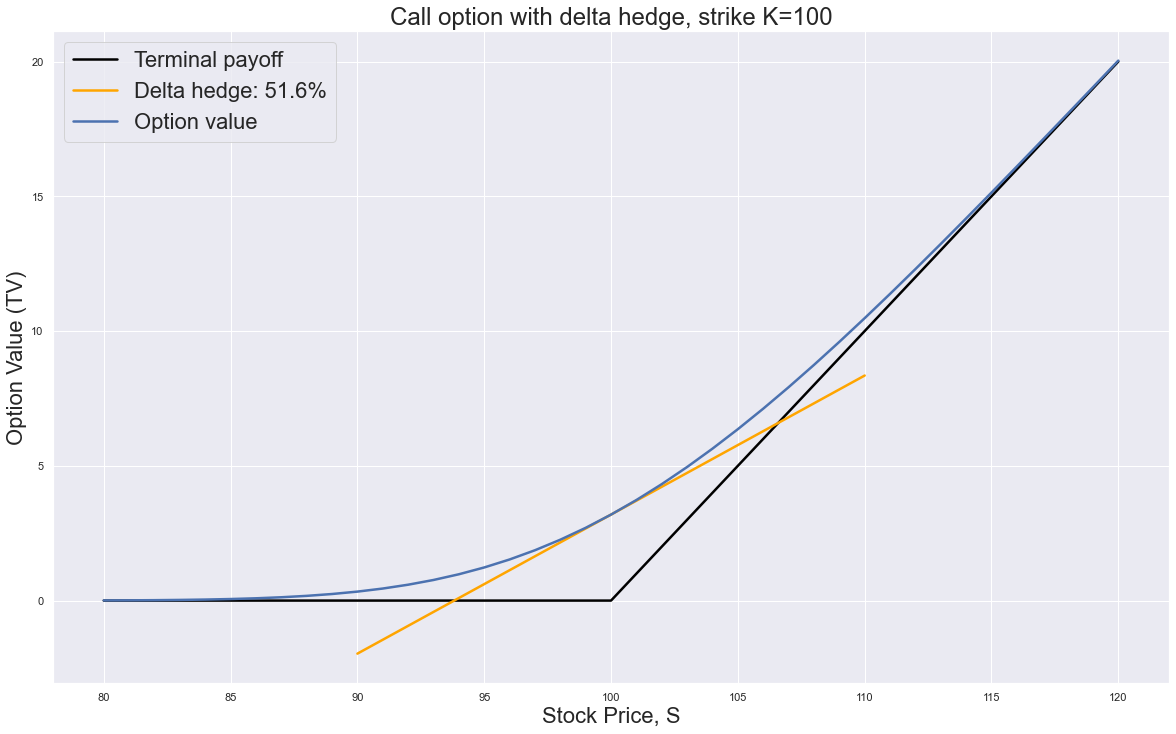

In [13]:
K = 100
sigma = 0.16
pxs = np.linspace(80, 120, 41)

call_pnls = [max(0, s - K) for s in pxs]
op_pxs = compute_prices(pxs, K, sigma, 0.25, call=True)
delta_hedge = [op_pxs[0][20] + op_pxs[1][20]* (p - 100) for p in np.linspace(90, 110, 21)]

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(pxs, call_pnls, lw=2.5, color='black', label='Terminal payoff')
ax.plot(np.linspace(90, 110, 21), delta_hedge, lw=2.5, color='orange', label='Delta hedge: {:.1%}'.format(op_pxs[1][20]))
ax.plot(pxs, op_pxs[0], lw=2.5, label='Option value')

ax.set_title('Call option with delta hedge, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

where we can see that we have marked on the delta as `51.6%` for this example in the legend. Now let's see what happens if we start moving the stock around - but instead of 'small moves', to prove a point let's make some larger exaggerated moves and re-hedge our call option each time.

## The stock rallies to `105`

So in this case we now have the stock rally 5% before we can adjust our hedge. Let's calculate what our appropriate delta hedge should be. For simplicity let's assume that no time has passed (move was instantaneous) and so we still have `t=0.25` years (i.e. 3 months).

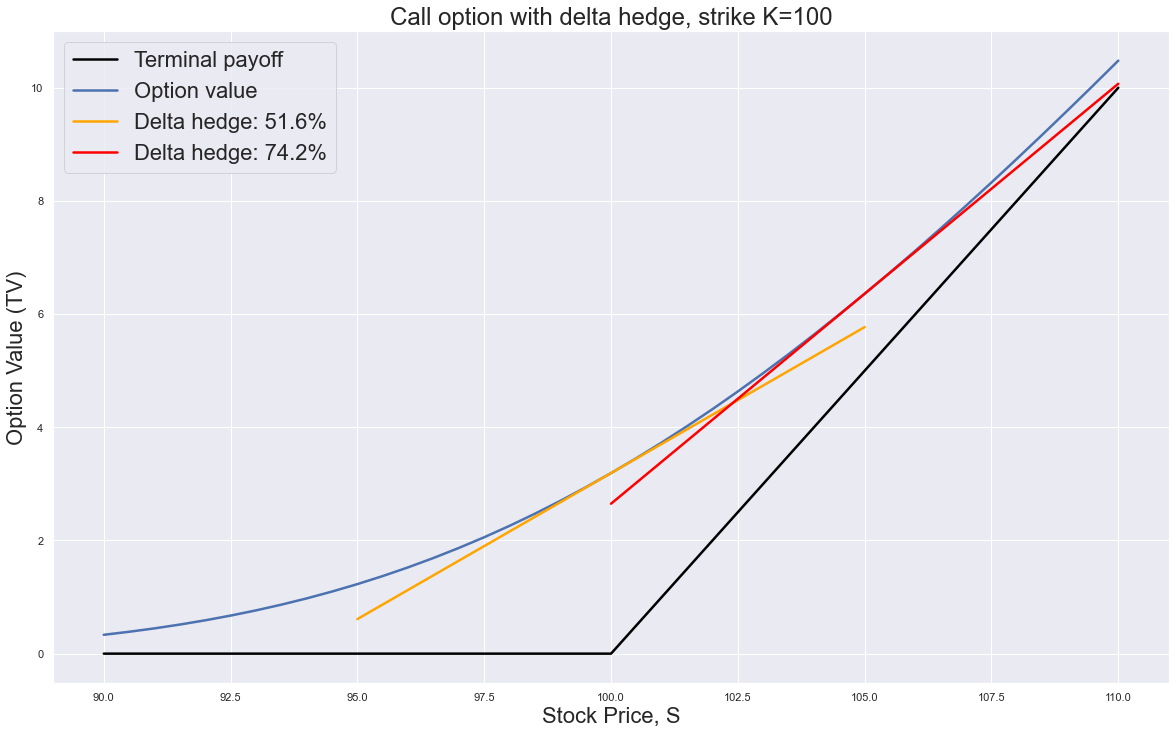

In [14]:
K = 100
sigma = 0.16
pxs = np.linspace(90, 110, 41)

call_pnls = [max(0, s - K) for s in pxs]
op_pxs = compute_prices(pxs, K, sigma, 0.25, call=True)

delta_hedge = [op_pxs[0][20] + op_pxs[1][20]* (p - 100) for p in np.linspace(95, 105, 11)]
delta_hedge_two = [op_pxs[0][30] + op_pxs[1][30] * (p - 105) for p in np.linspace(100, 110, 11)]

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(pxs, call_pnls, lw=2.5, color='black', label='Terminal payoff')
ax.plot(pxs, op_pxs[0], lw=2.5, label='Option value')

ax.plot(np.linspace(95, 105, 11), delta_hedge, lw=2.5, color='orange', label='Delta hedge: {:.1%}'.format(op_pxs[1][20]))
ax.plot(np.linspace(100, 110, 11), delta_hedge_two, lw=2.5, color='red', label='Delta hedge: {:.1%}'.format(op_pxs[1][30]))

ax.set_title('Call option with delta hedge, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

So we have the same graph as before but we are now at `S=105` and our appropriate delta hedge is the red line, not the orange line. As we can see from the legend of the graph we have gone from:
 - needing to have sold around `50` shares as the delta hedge to...
 - needing to have sold around `75` shares as the delta hedge

No bother - let's just sell those extra `25` shares at `105` and move on. We are now short `75` shares overall.

## The stock now sells off to `95`

In a turn of events the stock now drops `10` from `105` to `95` - again we haven't had the chance to adjust our delta as we have 'sold off'. But let's do the same as what we have done above - let's re-compute our delta, re-draw the graph and then buy or sell shares accordingly to re-balance our delta to the appropriate amount.

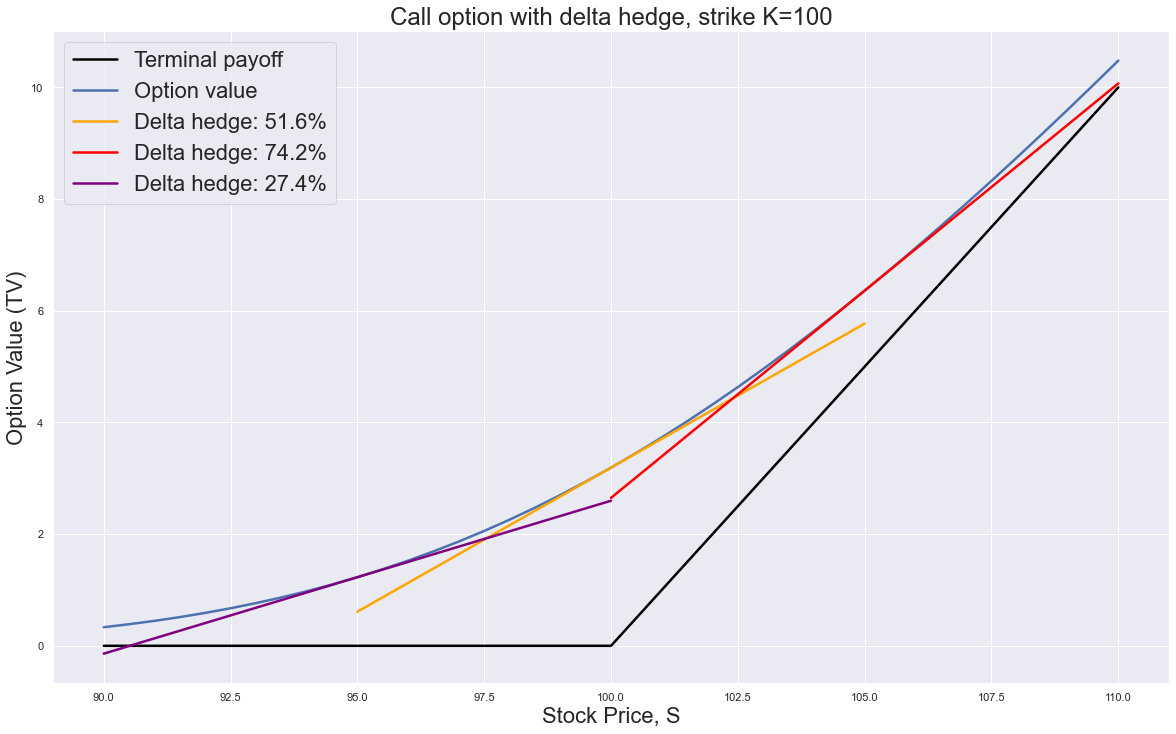

In [15]:
delta_hedge_three = [op_pxs[0][10] + op_pxs[1][10] * (p - 95) for p in np.linspace(90, 100, 11)]

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(pxs, call_pnls, lw=2.5, color='black', label='Terminal payoff')
ax.plot(pxs, op_pxs[0], lw=2.5, label='Option value')

ax.plot(np.linspace(95, 105, 11), delta_hedge, lw=2.5, color='orange', label='Delta hedge: {:.1%}'.format(op_pxs[1][20]))
ax.plot(np.linspace(100, 110, 11), delta_hedge_two, lw=2.5, color='red', label='Delta hedge: {:.1%}'.format(op_pxs[1][30]))
ax.plot(np.linspace(90, 100, 11), delta_hedge_three, lw=2.5, color='purple', label='Delta hedge: {:.1%}'.format(op_pxs[1][10]))

ax.set_title('Call option with delta hedge, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

So the same graph again, but this time we are down at the purple line and as the legend shows our delta is now roughly `25%`. However as per our delta hedge at `S=105` we had sold `75` shares. This is too many as we only need to be short `25` now. As a result let's buy back `50` shares at `95` so that we are all balanced again.

## Finally the price moves back up to `100`

There's no need to re-do the chart again here but we need to make our final delta hedge. So we're back where we started and we need to hold short `50` shares as our delta hedge but we are currently only short `25`. As a result let's sell a final `25` shares at `100` each.

## What was the point of that?

Assuming this all happened instantaneously and nothing else changed then we are exactly back where we started and:
 - we have the exact same call options worth the same as we started
 - we have the same delta hedge (short `50` shares) with the stock where we started at `S=100`

On the surface all we have done is buy and sell some stock according to what the slope of the graph told us to 'locally neutralise' the impact of the underlying stock price move on our option price. When the underlying stock price went up, so too did our option price however we lost on the delta hedge (because we had sold shares). __However because the move was not 'small' our delta changed and as a result we had to change our delta hedge by selling more shares.__ The reverse was true when the underlying stock price went down - we had to buy back those shares that we had sold because the option delta decreased (the slope was closer to `25%` at `S=95`).

__If you look carefully though we have just made some money.__

Why? __Because just by following the 'risk-minimisation' strategy of making sure at each point in time we have the correct amount of shares according to our delta, we have bought low and sold high.__ We can prove this by looking at the cash we have generated by re-balancing our delta. We start and finish with `50` shares however along the way we:
 - sell `25` at `105`
 - buy back `50` at `95`
 - sell `25` at `100`

And so in the process we have effectively bought `50` at `95` and sold half at `100` and the other half at `105` - so we should have made `125` + `250` = `375`. Why? __Because when it comes to moves that aren't 'small' our delta _changes_ and the process of adjusting to match this delta means that we buy low and sell high__.

## What factors impact how much money we make doing this process?

Using the above example we can now tease out some of the things that affect the price of an option. We will make more money doing this process when we have:
 - more time to do it: the more up and down moves we have to buy and sell the more we can make
 - bigger stock price moves: the bigger the moves, the bigger the differences between the prices we buy (low) and sell (high) at
 - bigger changes in delta: this means we need to buy and sell more stock to re-balance our delta

If we just focus on the last point we can now understand why in the above graphs the time value of the options (the difference between the curvy line and the terminal payoff 'hockey stick' line) is maximised around the strike, `K`. Because the delta changes _most_ here so if the underlying stays around here and moves up/down/up/down then time spent here is more valuable than time spent way above (ITM) or way below (OTM). This is because the bigger changes in delta mean for the same move in the underlying stock price we will be forced to buy and sell larger quantities of stock to hedge our delta. This generates more cash.

This variation in delta is referred to as '__gamma__' and refers to how the delta changes for an option as the underlying stock price moves.

## Why doesn't everyone do this? Why don't we all just buy options?

Again we're back to the same point as before - if we can make money doing this why don't we all do it. And the answer is the same as before - __because you have to pay for it__. Just as before when we examined buying an option just by looking at the 'hockey stick' graphs things looked much worse when we factored in the premium, `P`, the same is true here.

Let's re-print the graph showing how the time value of an option 'decays' as we have shorter and shorter time to expiry.

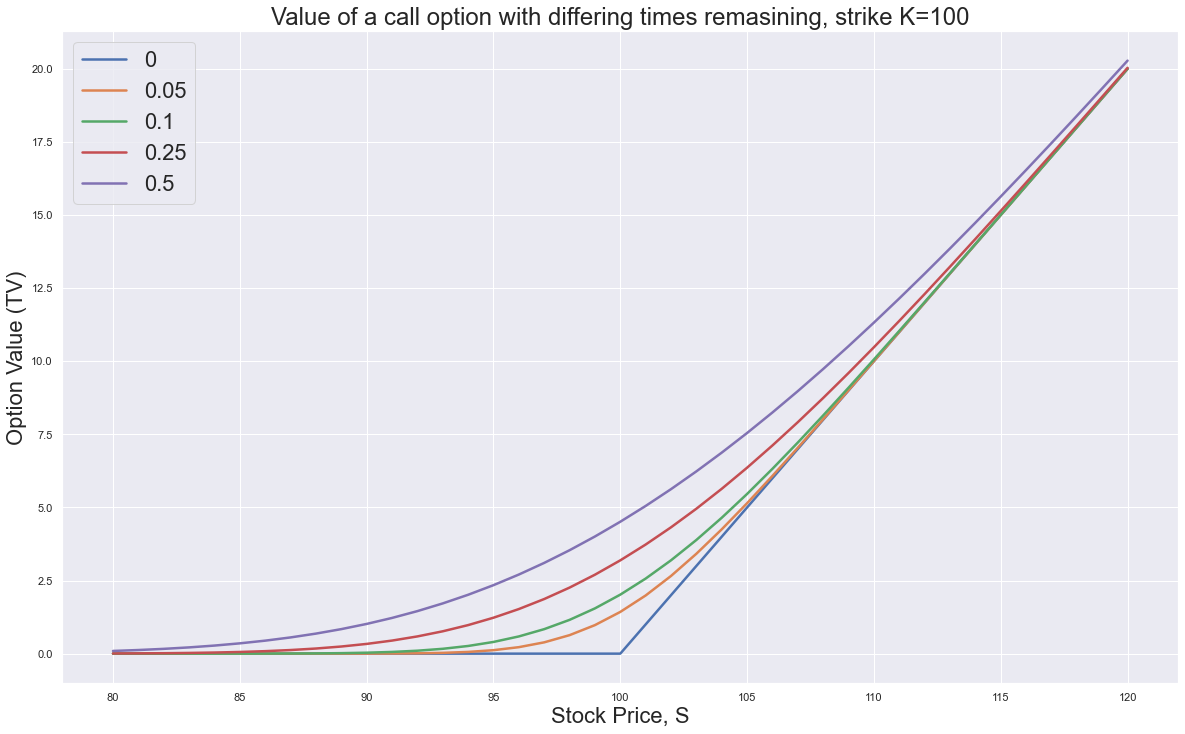

In [16]:
# functions to compute Black-Scholes option prices
def bs_d_one(S, K, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (sigma**2)/2 * delta_T)

def compute_prices(pxs, K, sigma, T, call=True):
    
    # calculate d1 and d2
    d_one = bs_d_one(pxs, K, sigma, T)
    d_two = d_one - sigma * T**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * deltas - stats.norm.cdf(d_two) * K
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K + deltas * pxs
    
    return prices, deltas


K = 100
sigma = 0.16
pxs = np.linspace(80, 120, 41)
times = [0.05, 0.1, 0.25, 0.5]
res = {}

for t in times:
    op_pxs = compute_prices(pxs, K, sigma, t, call=True)
    res[t] = op_pxs[0]

fig, ax = plt.subplots(figsize=(20,12))

call_pnls = [max(0, s - K) for s in pxs]
ax.plot(pxs, call_pnls, lw=2.5, label='0')

for l, ps in res.items():
    ax.plot(pxs, ps, lw=2.5, label=l)

ax.set_title('Value of a call option with differing times remasining, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

So as time passes the option losses value. To take an example if we buy the ATM call option in the above with `t=1` years to expiry and we happen to then sell it back with `t=0.25` years left (assuming nothing else changes i.e. stock price happens to be back at `S=100` etc) then we will have gone from it being worth `6.38` to `3.19` and lost `3.19` (this symmetry of value lost and remaining value is not an accident, but due to time value decaying with the square root of time).

How do we make this money back? __By delta hedging__. Under the assumptions we have used to value the option there is an implied amount of money we should have made from this behaviour of buying low, selling high, buying low, selling high. What we are saying is that there is a certain amount of money we are expected to make from this behaviour that _offsets_ the value of the option decreasing as time passes (known as the option 'decaying').

## How do you work out how much this should be?

Again we're back to the central idea of how to value an option - however I think we've got there from the much more intuitive practical explanation of delta-hedging replication rather than the usual method of distributional assumptions and brownian motion jargon. Sure everything so far has been a bit mathematically vague but the core concepts are all that matter. The mathematical relations can get added in as we go and starting with them is bonkers because:
 - they just confuse
 - most of them are wrong (normally distributed returns lol)

Most of the above has then been alluding to the following conclusion. Through this process of delta-hedging and rebalancing we have found a way to try to 'replicate' the option. We have taken the example where we have _bought_ the option but in the case of replication you would _sell_ the option - then buy and sell the stock according to the delta to create the same payoff.

This is the key takeaway - the cost of this replication should serve as a guideline for how we should price the option - rather than the more naive approaches (charging maximum) that we threw out there in the beginning. If the replication costs a lot then the option should cost a lot and vice versa. In the case of the perfect (but unrealistic) assumptions knocked out in the Black-Scholes model the cost of the option will be exactly equal to the cost of this perfect dynamic continuous replication.

## 'Volatility' is what matters

This process of the stock going up and down and up and down has a name - volatility. Now we have a clear way of showing that the more volatile a stock is the more a call option should cost - because the higher the volatility the more we will make from the above process of delta hedging (and the more the person who sold us the option will lose doing the reverse). As such they need to be compensated by charging more for it - so that the decay of the option is greater thus better offsetting their daily loses from rebalancing.

To me this is a much more intuitive way of explaining how the idea of buying options is synonymous with 'buying volatility' rather than the usual argument wheeled out that:

_"more volatility means there is more chance of the stock ending up much higher and so this makes the option worth more"_

Again this appeals to distributional assumptions (that the final stock price distribution is wider and we only need to care about the upside because we don't lose anything on the down side) which:
 - aren't very easy to visualise
 - don't really explain how this all links to the day to day activity of risk managing a derivatives trading desk

## Loose ends

Hopefully this has been quite a smooth ride with lots of visual cues to explain how the idea of volatility and delta-hedging is linked - more volatility makes you more money when you are long an option from this rebalancing of delta behaviour.

However it's not quite this simple. We haven't discussed at all how we calculated that delta number, nor any of the other intricacies with option pricing (e.g. we've focussed on just `S` and not the forward price `F` because we've assumed zero interest rates and dividends), but the core points remain even when these things are re-introduced.

The real question is how well this works in practise - __even if we do know all this input information perfectly__. In other words - if all I need to do is compute the delta for an option and then re-balance it then what's so hard about the job?

To look at this we will:
 - build a Monte Carlo stock price simulator (sounds fancier than it is)
 - use that to build an option price delta hedged portfolio generator
 - compare how the above delta hedged replication strategy actually compares to the terminal payoff of an option

It turns out that in reality the standard deviation of blindly delta-hedging is far far too big for this to be the primary risk management strategy giving rise to the common expression: 'options hedge options' (not delta).